In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults



In [3]:
import sklearn
from sklearn.model_selection import train_test_split # divide dados de treino / teste
from sklearn.preprocessing import StandardScaler # Padronização
from sklearn.linear_model import LinearRegression # Regressão linear
from sklearn.linear_model import Ridge # Regressão Ridge
from sklearn.linear_model import Lasso # Regressão Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score # Métricas para regressão
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from datetime import datetime as dt


#### IMPORTANDO O DF ALIMENTAÇÃO

In [4]:
df_alimentacao = pd.read_csv("../data/dados_para_processamento/df_alimentacao.csv", sep =',',
                              parse_dates = ['ds'],
                              encoding = 'utf-8')
#df_alimentacao = df_alimentacao[df_alimentacao['Data_Venda'] != '2020-01']

In [5]:
df_alimentacao = df_alimentacao[df_alimentacao.ds != '2020-01-01'].sort_index(ascending= True)

In [6]:
df_alimentacao

,Produto,y,ds
0,Cabo de Carregamento Turbo,1,2019-01-01
1,Pilhas AAA (4 Unidades),1,2019-01-01
2,Cabo de Carregamento USB-C,1,2019-01-01
3,Pilhas AAA (4 Unidades),3,2019-01-01
4,Cabo de Carregamento USB-C,1,2019-01-01
...,...,...,...
84774,Pilhas AAA (4 Unidades),2,2019-12-01
84775,Cabo de Carregamento Turbo,1,2019-12-01
84776,Pilhas AAA (4 Unidades),1,2019-12-01
84777,Cabo de Carregamento Turbo,1,2019-12-01


In [7]:
df_alimentacao.info(10)

<class 'pandas.core.frame.DataFrame'>
Index: 84767 entries, 0 to 84778
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Produto  84767 non-null  object        
 1   y        84767 non-null  int64         
 2   ds       84767 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.6+ MB


In [8]:
df_alimentacao.head(8)

,Produto,y,ds
0,Cabo de Carregamento Turbo,1,2019-01-01
1,Pilhas AAA (4 Unidades),1,2019-01-01
2,Cabo de Carregamento USB-C,1,2019-01-01
3,Pilhas AAA (4 Unidades),3,2019-01-01
4,Cabo de Carregamento USB-C,1,2019-01-01
5,Pilhas AA (4 Unidades),1,2019-01-01
6,Pilhas AAA (4 Unidades),1,2019-01-01
7,Cabo de Carregamento USB-C,1,2019-01-01


In [9]:
df_alimentacao_2 = df_alimentacao.groupby(['ds', 'Produto'])["y"].sum().reset_index()

In [10]:
df_alimentacao_2.head(10)

,ds,Produto,y
0,2019-01-01,Cabo de Carregamento Turbo,1149
1,2019-01-01,Cabo de Carregamento USB-C,1283
2,2019-01-01,Pilhas AA (4 Unidades),1424
3,2019-01-01,Pilhas AAA (4 Unidades),1595
4,2019-02-01,Cabo de Carregamento Turbo,1499
5,2019-02-01,Cabo de Carregamento USB-C,1654
6,2019-02-01,Pilhas AA (4 Unidades),1735
7,2019-02-01,Pilhas AAA (4 Unidades),1972
8,2019-03-01,Cabo de Carregamento Turbo,1873
9,2019-03-01,Cabo de Carregamento USB-C,1944


In [11]:
df_alimentacao_2.columns

Index(['ds', 'Produto', 'y'], dtype='object')

In [12]:
df_pilha_AAA = df_alimentacao_2[df_alimentacao_2['Produto'] == 'Pilhas AAA (4 Unidades)']


In [13]:
df_pilha_AAA = df_pilha_AAA.drop(columns = {'Produto'})

In [14]:
df_pilha_AAA = df_pilha_AAA.set_index('ds')['y']

In [15]:
df_pilha_AAA

ds
2019-01-01    1595
2019-02-01    1972
2019-03-01    2479
2019-04-01    2939
2019-05-01    2927
2019-06-01    2162
2019-07-01    2365
2019-08-01    2021
2019-09-01    1923
2019-10-01    3363
2019-11-01    3025
2019-12-01    4241
Name: y, dtype: int64

In [16]:
# Ajustando Freq para Mensal
df_pilha_AAA = df_pilha_AAA.asfreq('MS')

In [17]:
# APLICANDO ARIMA 

model_arima = ARIMA(df_pilha_AAA, order=(0, 1, 2))
fit_arima = model_arima.fit()

# Fazer previsões para os próximos meses
forecast_arima = fit_arima.forecast(steps=2)

# Exibir as previsões
print("Previsões ARIMA:")
print(forecast_arima)

c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Previsões ARIMA:
2020-01-01    4164.721860
2020-02-01    4417.699741
Freq: MS, Name: predicted_mean, dtype: float64


In [18]:
best_aic = float('inf')
best_order = None

for p in range(3):  # Testar valores de p de 0 a 2
    for d in range(2):  # Testar valores de d de 0 a 1
        for q in range(3):  # Testar valores de q de 0 a 2
            try:
                model = ARIMA(df_pilha_AAA, order=(p, d, q))
                fit = model.fit()
                aic = fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
            except:
                pass 

print("Melhor ordem (p, d, q) com base no AIC:", best_order)
print("Melhor valor do AIC:", best_aic)

c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\alyss\anaconda3\lib\s

Melhor ordem (p, d, q) com base no AIC: (0, 1, 2)
Melhor valor do AIC: 174.95057639890192


c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
forecast_arima

2020-01-01    4164.721860
2020-02-01    4417.699741
Freq: MS, Name: predicted_mean, dtype: float64

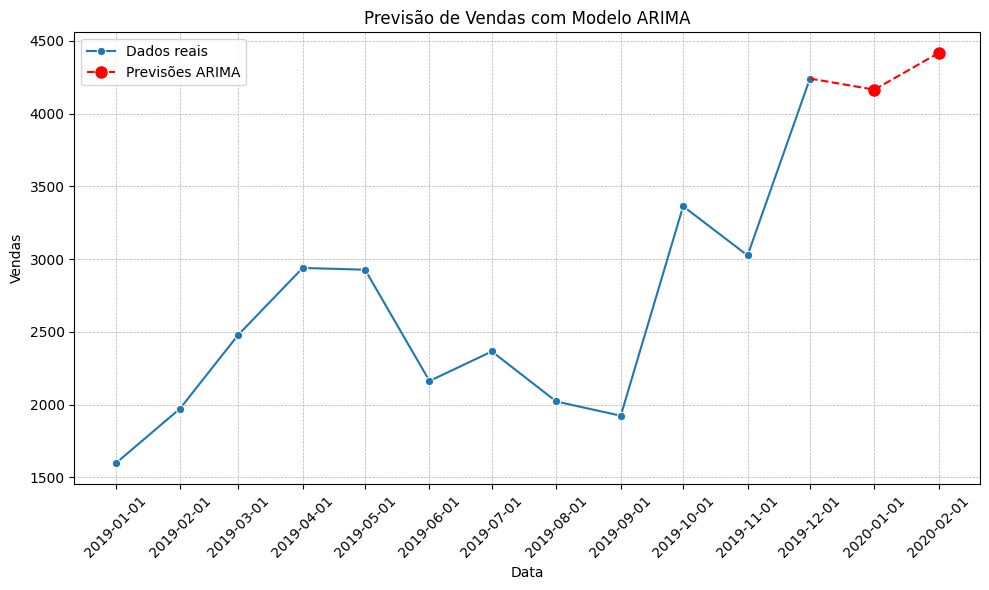

In [20]:
# Criar o gráfico
plt.figure(figsize=(10, 6))

# Plotar os dados reais
sns.lineplot(x=df_pilha_AAA.index, y=df_pilha_AAA.values, label='Dados reais', marker='o')

# Plotar as previsões do modelo ARIMA com linha de grid nos pontos
plt.plot(forecast_arima.index, forecast_arima.values, color='red', linestyle='--', label='Previsões ARIMA', marker='o', markersize=8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adicionar linha de grid nos pontos das previsões

# Adicionar uma linha conectando os últimos pontos dos dados reais com o primeiro ponto das previsões
plt.plot([df_pilha_AAA.index[-1], forecast_arima.index[0]], [df_pilha_AAA.values[-1], forecast_arima.values[0]], color='red', linestyle='--')

# Adicionar rótulos e título
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Previsão de Vendas com Modelo ARIMA')
plt.legend()

# Ajustar os ticks do eixo x para todos os meses
plt.xticks(pd.date_range(start=df_pilha_AAA.index[0], end=forecast_arima.index[-1], freq='MS'), rotation=45)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [36]:
list_alimentacao = df_alimentacao_2.Produto.unique()

In [39]:
list_alimentacao

array(['Cabo de Carregamento Turbo', 'Cabo de Carregamento USB-C',
       'Pilhas AA (4 Unidades)', 'Pilhas AAA (4 Unidades)'], dtype=object)

In [58]:
# Loop para passar por todos os elementos
def preparaDF(df):

 for produto in list_alimentacao:
   novo_df = df[df['Produto'] == produto]
   novo_df = novo_df.drop(columns = {'Produto'})
   novo_df = novo_df.set_index('ds')['y']
   novo_df = novo_df.asfreq('MS')
   print(produto)

    #ARIMA
   model_arima = ARIMA(novo_df, order=(0, 1, 2))
   fit_arima = model_arima.fit()

   forecast_arima = fit_arima.forecast(steps=2) 
   print(forecast_arima)
   print("Previsões ARIMA:")

   plt.figure(figsize=(10, 6))

   sns.lineplot(x=novo_df.index, y=novo_df.values, label='Dados reais', marker='o')

   # Plotar as previsões do modelo ARIMA com linha de grid nos pontos
   plt.plot(forecast_arima.index, forecast_arima.values, color='red', linestyle='--', label='Previsões ARIMA', marker='o', markersize=8)
   plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adicionar linha de grid nos pontos das previsões

   # Adicionar uma linha conectando os últimos pontos dos dados reais com o primeiro ponto das previsões
   plt.plot([novo_df.index[-1], forecast_arima.index[0]], [novo_df.values[-1], forecast_arima.values[0]], color='red', linestyle='--')

   # Adicionar rótulos e título
   plt.xlabel('Data')
   plt.ylabel('Vendas')
   plt.title(f'Previsão de Vendas - {produto}')
   plt.legend()

   # Ajustar os ticks do eixo x para todos os meses
   plt.xticks(pd.date_range(start=novo_df.index[0], end=forecast_arima.index[-1], freq='MS'), rotation=45)

   # Mostrar o gráfico
   plt.tight_layout()
   plt.show()


Cabo de Carregamento Turbo
2020-01-01    3052.713152
2020-02-01    3127.448472
Freq: MS, Name: predicted_mean, dtype: float64
Previsões ARIMA:


c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


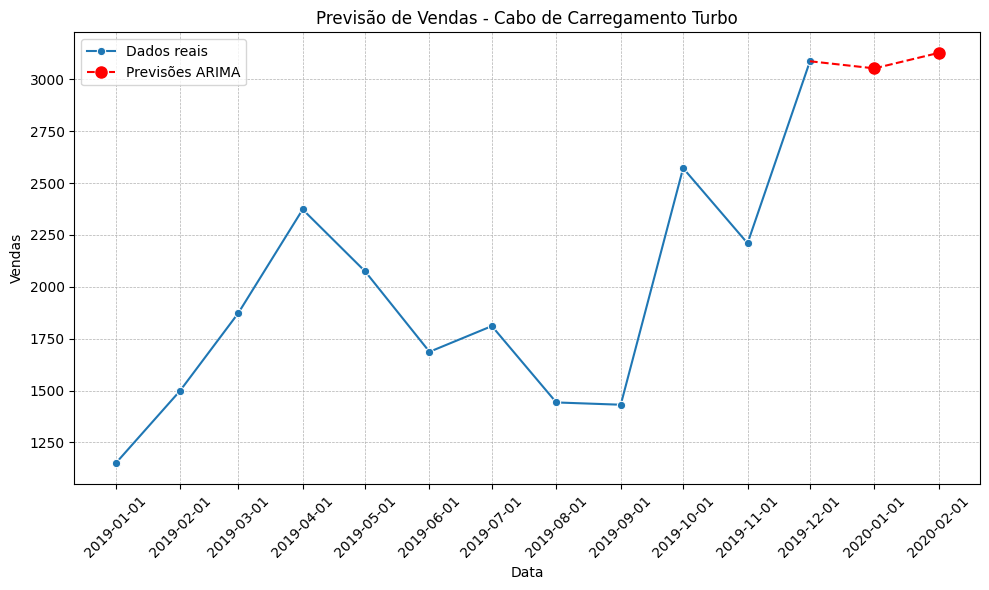

Cabo de Carregamento USB-C
2020-01-01    3105.139937
2020-02-01    3221.584793
Freq: MS, Name: predicted_mean, dtype: float64
Previsões ARIMA:


c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


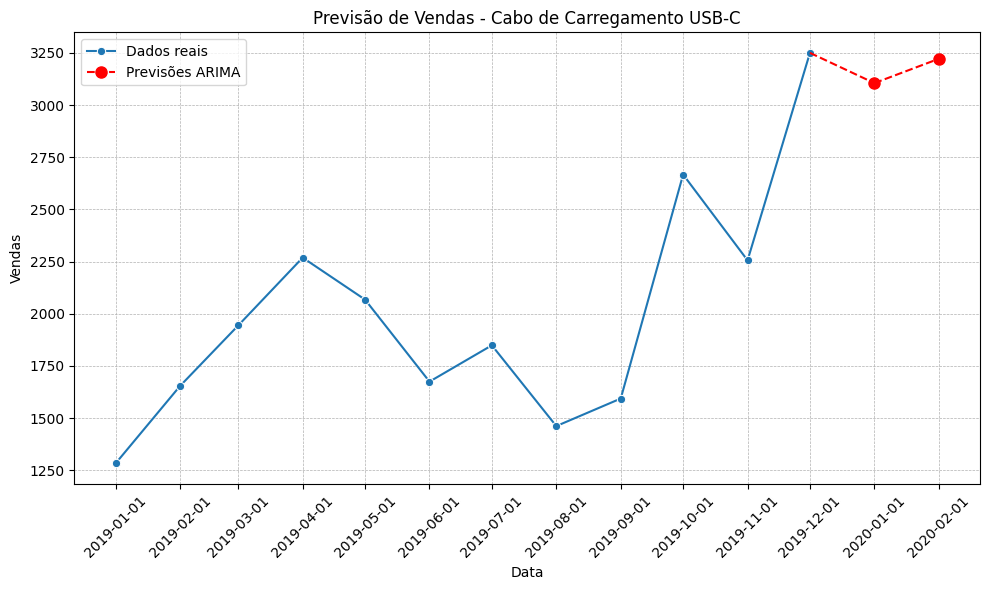

Pilhas AA (4 Unidades)
2020-01-01    3657.565277
2020-02-01    3956.725954
Freq: MS, Name: predicted_mean, dtype: float64
Previsões ARIMA:


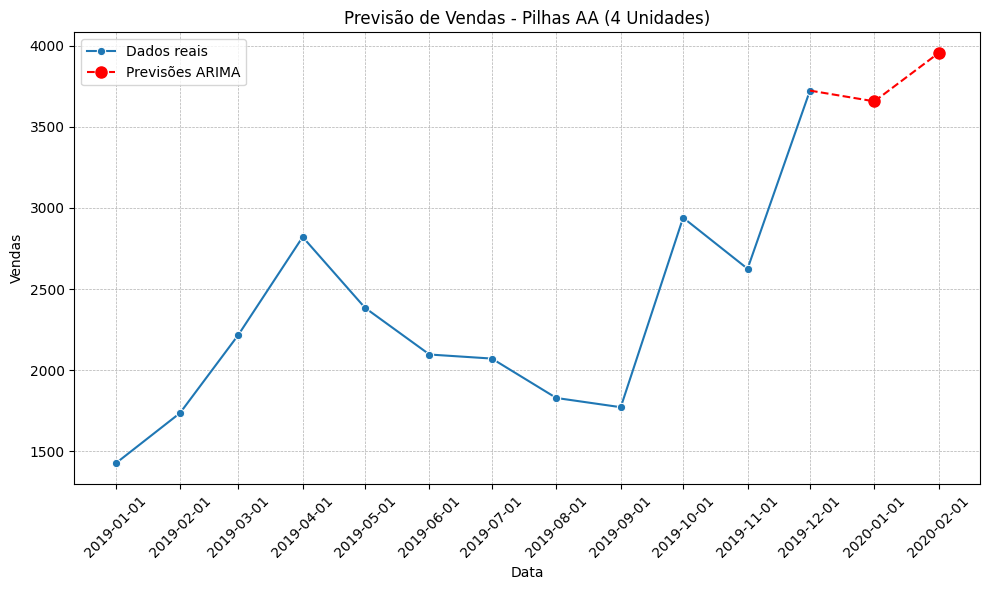

Pilhas AAA (4 Unidades)
2020-01-01    4164.721860
2020-02-01    4417.699741
Freq: MS, Name: predicted_mean, dtype: float64
Previsões ARIMA:


c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


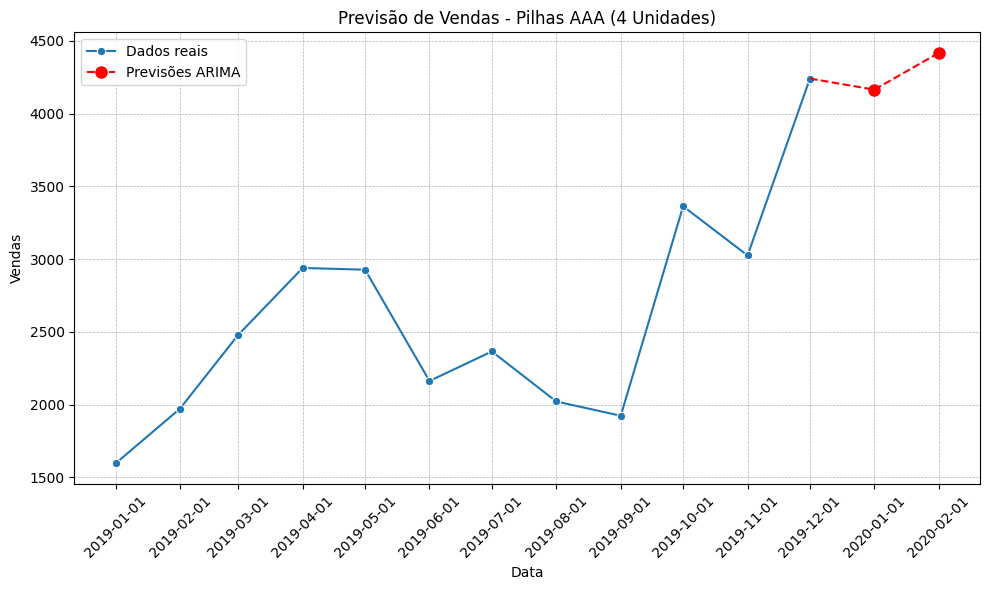

In [59]:
preparaDF(df_alimentacao_2)

In [118]:
def preparaDF(df, list_alimentacao):
    fig, axs = plt.subplots(len(list_alimentacao)//2, 2, figsize=(15, 12))

    for i, produto in enumerate(list_alimentacao):
        novo_df = df[df['Produto'] == produto]
        novo_df = novo_df.drop(columns={'Produto'})
        novo_df = novo_df.set_index('ds')['y']
        novo_df = novo_df.asfreq('MS')

        # ARIMA
        model_arima = ARIMA(novo_df, order=(0, 1, 2))
        fit_arima = model_arima.fit()

        forecast_arima = fit_arima.forecast(steps=2)

        sns.set_palette("OrRd")

        row = i // 2
        col = i % 2

        axs[row, col].plot(novo_df.index, novo_df.values, label='Dados reais', marker='o')
        axs[row, col].plot(forecast_arima.index, forecast_arima.values, color='red', linestyle='--', label='Previsões ARIMA', marker='o', markersize=8)
        axs[row, col].grid(True, which='both', linestyle='--', linewidth=0.3)
        axs[row, col].plot([novo_df.index[-1], forecast_arima.index[0]], [novo_df.values[-1], forecast_arima.values[0]], color='red', linestyle='--')

        axs[row, col].set_xlabel('Mês')
        axs[row, col].set_ylabel('Quantitativo de Vendas')
        axs[row, col].set_title(f'Previsão de Vendas - {produto}', y=1.05)
        axs[row, col].legend()
        axs[row, col].set_xticks(pd.date_range(start=novo_df.index[0], end=forecast_arima.index[-1], freq='MS'))
        
        axs[row, col].tick_params(axis='x', rotation=45, colors='gray') # Definindo cor cinza para os ticks do eixo x
        axs[row, col].tick_params(axis='y', colors='gray') # Definindo cor 

        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()

c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\alyss\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


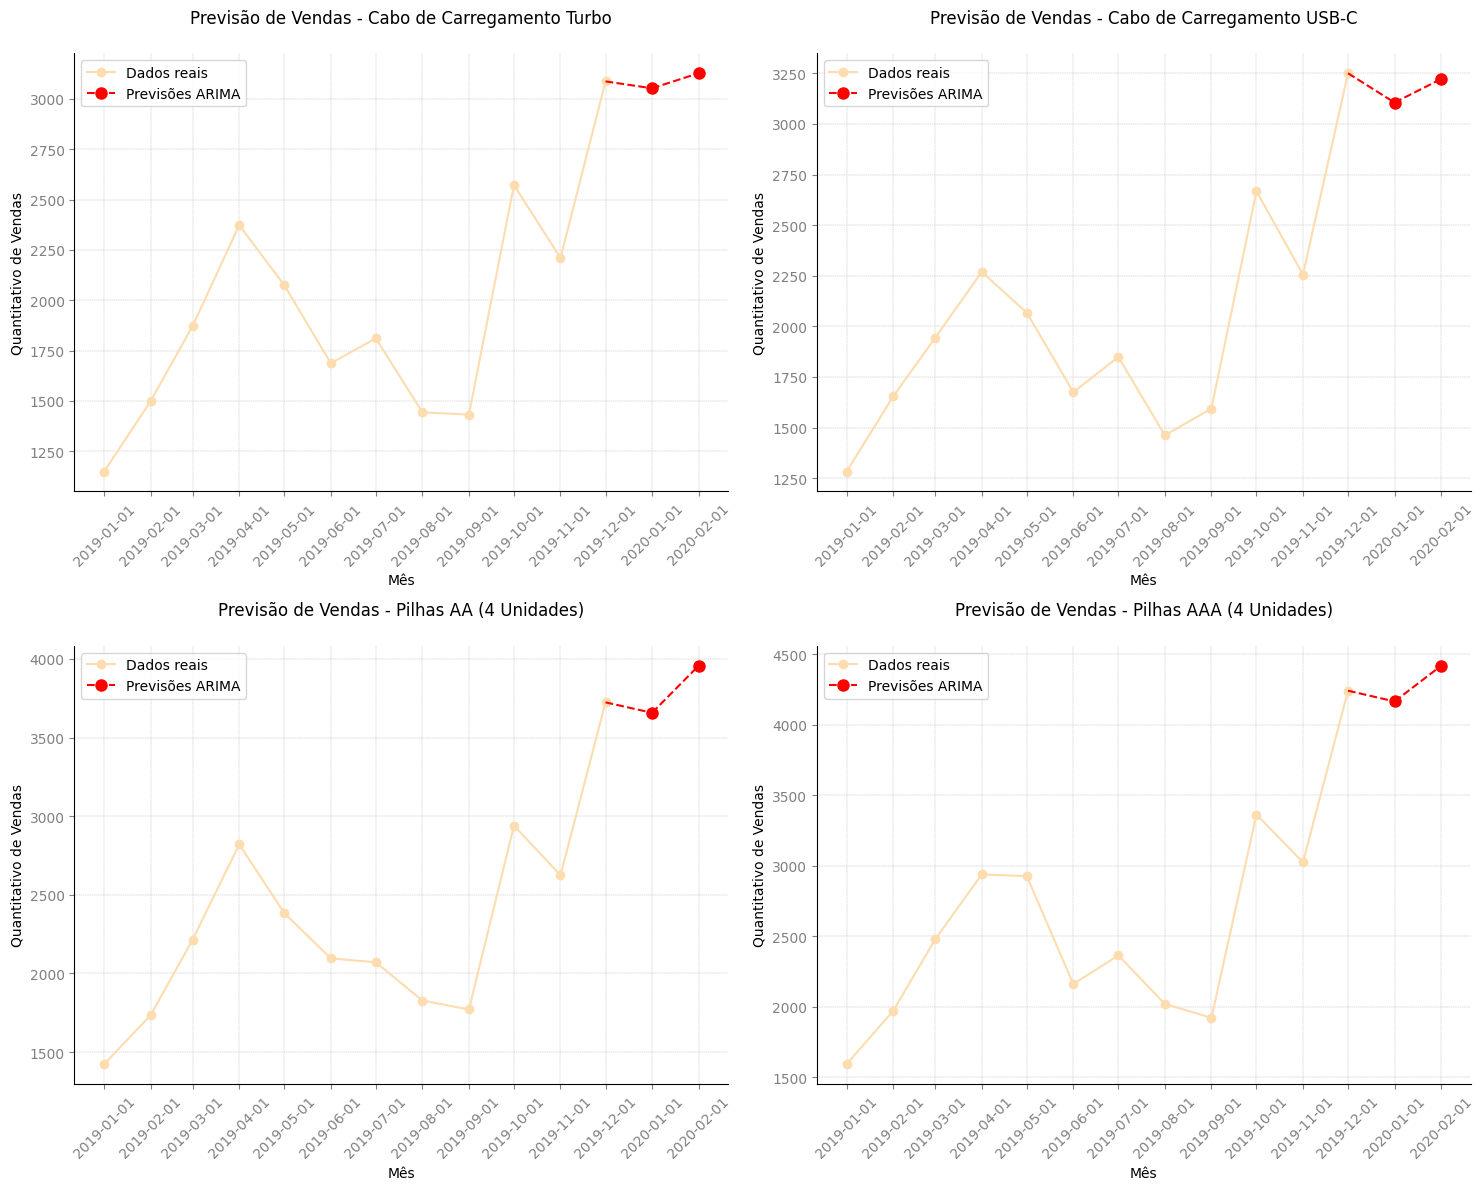

In [122]:
list_alimentacao = df_alimentacao_2['Produto'].unique()

sns.set_palette("OrRd", 4)

preparaDF(df_alimentacao_2, list_alimentacao)

In [70]:
map_data = {
 '2019-01-01': 'Jan/2019',
 '2019-02-01': 'Fev/2019',
 '2019-03-01': 'Mar/2019',
 '2019-04-01': 'Abr/2019',
 '2019-05-01': 'Maio/2019',
 '2019-06-01': 'Jun/2019',
 '2019-07-01': 'Jul/2019',
 '2019-08-01': 'Ago/2019',
 '2019-09-01': 'Set/2019',
 '2019-10-01': 'Out/2019',
 '2019-11-01': 'Nov/2019',
 '2019-12-01': 'Dez/2019',
 '2020-01-01': 'Jan/2020',
 '2020-02-01': 'Fev/2020',
}